In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import pandas as pd

from scipy.io import mmread
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt


In [2]:
def filter_X(genes, X, kept_list):
    gene_dict = {gene:idx for idx, gene in enumerate(genes)}
    indices = [gene_dict[gene] for gene in kept_list]
    return X.tocsr()[:, indices]

def get_batch_info(postfix, ids, df):
    df.index = ids
    target_ids = [id for id in ids if id.endswith(postfix)]
    df = df.loc[target_ids]
    df.index = [id.split("_")[0] for id in df.index]
    return df


    

def load_adata():
    df_tsne_pca = pd.read_csv("/data/groups/yhhuang/veloData/intestine/atlas_tSNE_PCA_update.txt", delimiter="\t")
    df_meta = pd.read_csv("/data/groups/yhhuang/veloData/intestine/atlas_metadata.txt", delimiter="\t")
    df_meta1 = get_batch_info("M2", df_meta.NAME, df_meta)
    df_tsne1 = get_batch_info("M2", df_tsne_pca.NAME, df_tsne_pca)
    df_meta2 = get_batch_info("M1", df_meta.NAME, df_meta)
    df_tsne2 = get_batch_info("M1", df_tsne_pca.NAME, df_tsne_pca)
    counts1 = mmread("/data/groups/yhhuang/veloData/intestine/bams/batch1/GSM2839445_Atlas1_matrix.mtx").T
    barcodes1 = pd.read_csv("/data/groups/yhhuang/veloData/intestine/bams/batch1/GSM2839445_Atlas1_barcodes.tsv", header=None).values.flatten()
    barcodes1 = [ba[:-2] for ba in barcodes1]
    genes1 = pd.read_csv("/data/groups/yhhuang/veloData/intestine/bams/batch1/GSM2839445_Atlas1_genes.tsv", header=None).values.flatten()
    counts2 = mmread("/data/groups/yhhuang/veloData/intestine/bams/batch2/GSM2839446_Atlas2_matrix.mtx.gz").T
    barcodes2 = pd.read_csv("/data/groups/yhhuang/veloData/intestine/bams/batch2/GSM2839446_Atlas2_barcodes.tsv", header=None).values.flatten()
    barcodes2 = [ba[:-2] for ba in barcodes2]
    genes2 = pd.read_csv("/data/groups/yhhuang/veloData/intestine/bams/batch2/GSM2839446_Atlas2_genes.tsv", header=None).values.flatten()

    genes1 = list(map( lambda x:x.split("\t")[-1], genes1))
    genes2 = list(map( lambda x:x.split("\t")[-1], genes2))

    adata1 = scanpy.read_loom("/data/groups/yhhuang/veloData/intestine/bams/batch1/velocyto_res/SRR6254355_Atlas1_MUYSH.loom")
    adata2 = scanpy.read_loom("/data/groups/yhhuang/veloData/intestine/bams/batch2/velocyto_res/SRR6254356_Atlas2_NBFHR.loom")
    adata1.var_names_make_unique()
    adata2.var_names_make_unique()

    ovl_genes1 = np.sort(np.intersect1d(genes1, adata1.var_names))
    ovl_genes2 = np.sort(np.intersect1d(genes2, adata2.var_names))

    adata1.obs.index = [ba.split(":")[-1][:-1] for ba in adata1.obs_names]
    adata2.obs.index = [ba.split(":")[-1][:-1] for ba in adata2.obs_names]
    # adata1.obs.index = list(map(lambda x:x.split(":")[-1][:-1] + '-1', adata1.obs_names))
    adata1 = adata1[barcodes1, ovl_genes1]
    adata2 = adata2[barcodes2, ovl_genes2]
    # adata2.obs.index = list(map(lambda x:x.split(":")[-1][:-1] + '-1', adata2.obs_names))
    adata1.X = filter_X(genes1, counts1, ovl_genes1)
    adata2.X = filter_X(genes2, counts2, ovl_genes2)

    adata1 = adata1[df_meta1.index]
    adata1.obs['cluster'] = df_meta1.Cluster
    adata1.obsm['X_umap'] = df_tsne1[["X", "Y"]].values
    adata1.obsm['X_pca'] = df_tsne1[["PC1",	"PC2", "PC3", "PC4", "PC5"]].values

    adata2 = adata2[df_meta2.index]
    adata2.obs['cluster'] = df_meta2.Cluster
    adata2.obsm['X_umap'] = df_tsne2[["X", "Y"]].values
    adata2.obsm['X_pca'] = df_tsne2[["PC1",	"PC2", "PC3", "PC4", "PC5"]].values

    adata = scanpy.concat([adata1, adata2])
    adata.obs_names_make_unique()
    # adata, adata1, adata2
    return adata



In [3]:
adata = load_adata()
adata

AnnData object with n_obs × n_vars = 2635 × 25716
    obs: 'cluster'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [4]:
# from matplotlib import pyplot as plt
# plt.boxplot(counts.sum(axis=1))
# plt.show()
# plt.boxplot(adata1.layers['spliced'].sum(axis=1) + adata1.layers['unspliced'].sum(axis=1))
# plt.show()
# plt.boxplot(adata2.layers['spliced'].sum(axis=1) + adata2.layers['unspliced'].sum(axis=1))
# inter_cells = (len(np.intersect1d(list(map(lambda x:x.split(":")[-1], adata1.obs_names)), list(map(lambda x:x.split(":")[-1], adata2.obs_names)))))
# union_cells = len(np.union1d(list(map(lambda x:x.split(":")[-1], adata1.obs_names)), list(map(lambda x:x.split(":")[-1], adata2.obs_names))))
# print(f"Run1: # cells: {adata1.shape[0]}, Run2: # cells: {adata2.shape[0]}\nIntercection: {inter_cells}, Union:{union_cells}")

In [5]:
# counts = mmread("/data/groups/yhhuang/veloData/intestine/bams/batch1/GSM2839445_Atlas1_matrix.mtx")
# counts = counts.T
# barcodes = pd.read_csv("/data/groups/yhhuang/veloData/intestine/bams/batch1/GSM2839445_Atlas1_barcodes.tsv", header=None)
# adata1 = scanpy.read_loom("/data/groups/yhhuang/veloData/intestine/bams/batch1/velocyto_res/SRR6254355_Atlas1_AT59D.loom")
# adata2 = scanpy.read_loom("/data/groups/yhhuang/veloData/intestine/bams/batch1/velocyto_res/SRR6985832_Atlas1_OJQBO.loom")
# adata1.var_names_make_unique()
# adata2.var_names_make_unique()

# from matplotlib import pyplot as plt
# plt.boxplot(counts.sum(axis=1))
# plt.show()
# plt.boxplot(adata1.layers['spliced'].sum(axis=1) + adata1.layers['unspliced'].sum(axis=1))
# plt.show()
# plt.boxplot(adata2.layers['spliced'].sum(axis=1) + adata2.layers['unspliced'].sum(axis=1))
# inter_cells = (len(np.intersect1d(list(map(lambda x:x.split(":")[-1], adata1.obs_names)), list(map(lambda x:x.split(":")[-1], adata2.obs_names)))))
# union_cells = len(np.union1d(list(map(lambda x:x.split(":")[-1], adata1.obs_names)), list(map(lambda x:x.split(":")[-1], adata2.obs_names))))
# print(f"Run1: # cells: {adata1.shape[0]}, Run2: # cells: {adata2.shape[0]}\nIntercection: {inter_cells}, Union:{union_cells}")

In [6]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'intestinal_model.cpt',
                               '--exp-name', 'CohAE_intestinal',
                               '--device', 'cuda:3',
                               '--gumbsoft_tau', '5',
                               '--n_raw_gene', '2000',
                              ])

In [7]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [8]:
cluster_edges = []
k_cluster = "cluster"
# k_cluster = "celltype" 
EXP_NAME = args.exp_name
exp_metrics = {}

In [9]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
        
    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [10]:
# adata = scv.datasets.dentategyrus_lamanno()
# adata = scv.datasets.bonemarrow()
# adata = scv.datasets.pbmc68k()
# adata = scanpy.read_loom("/data/users/cqiao/projects/veloAE_rev2/VeloRep/mRNA_2_PBMCs_possorted_genome_bam_BJ2UE.loom")
# adata.obsm['X_umap'] = np.concatenate([adata.obs._X.values.reshape(-1, 1), adata.obs._Y.values.reshape(-1,1)], axis=1)
# adata.var_names_make_unique()
# scv.pp.remove_duplicate_cells(adata)
# adata.obsm["X_tsne"][:, 0] *= -1
# adata.obsm['X_umap'] = adata.obsm["X_tsne"]
# adata.obsm['X_umap'] = adata.obsm["X_pca"]
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.81 0.19]
Filtered out 21975 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:21) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 2635 × 2000
    obs: 'cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:01) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:08) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:02) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_intestinal_stc.png


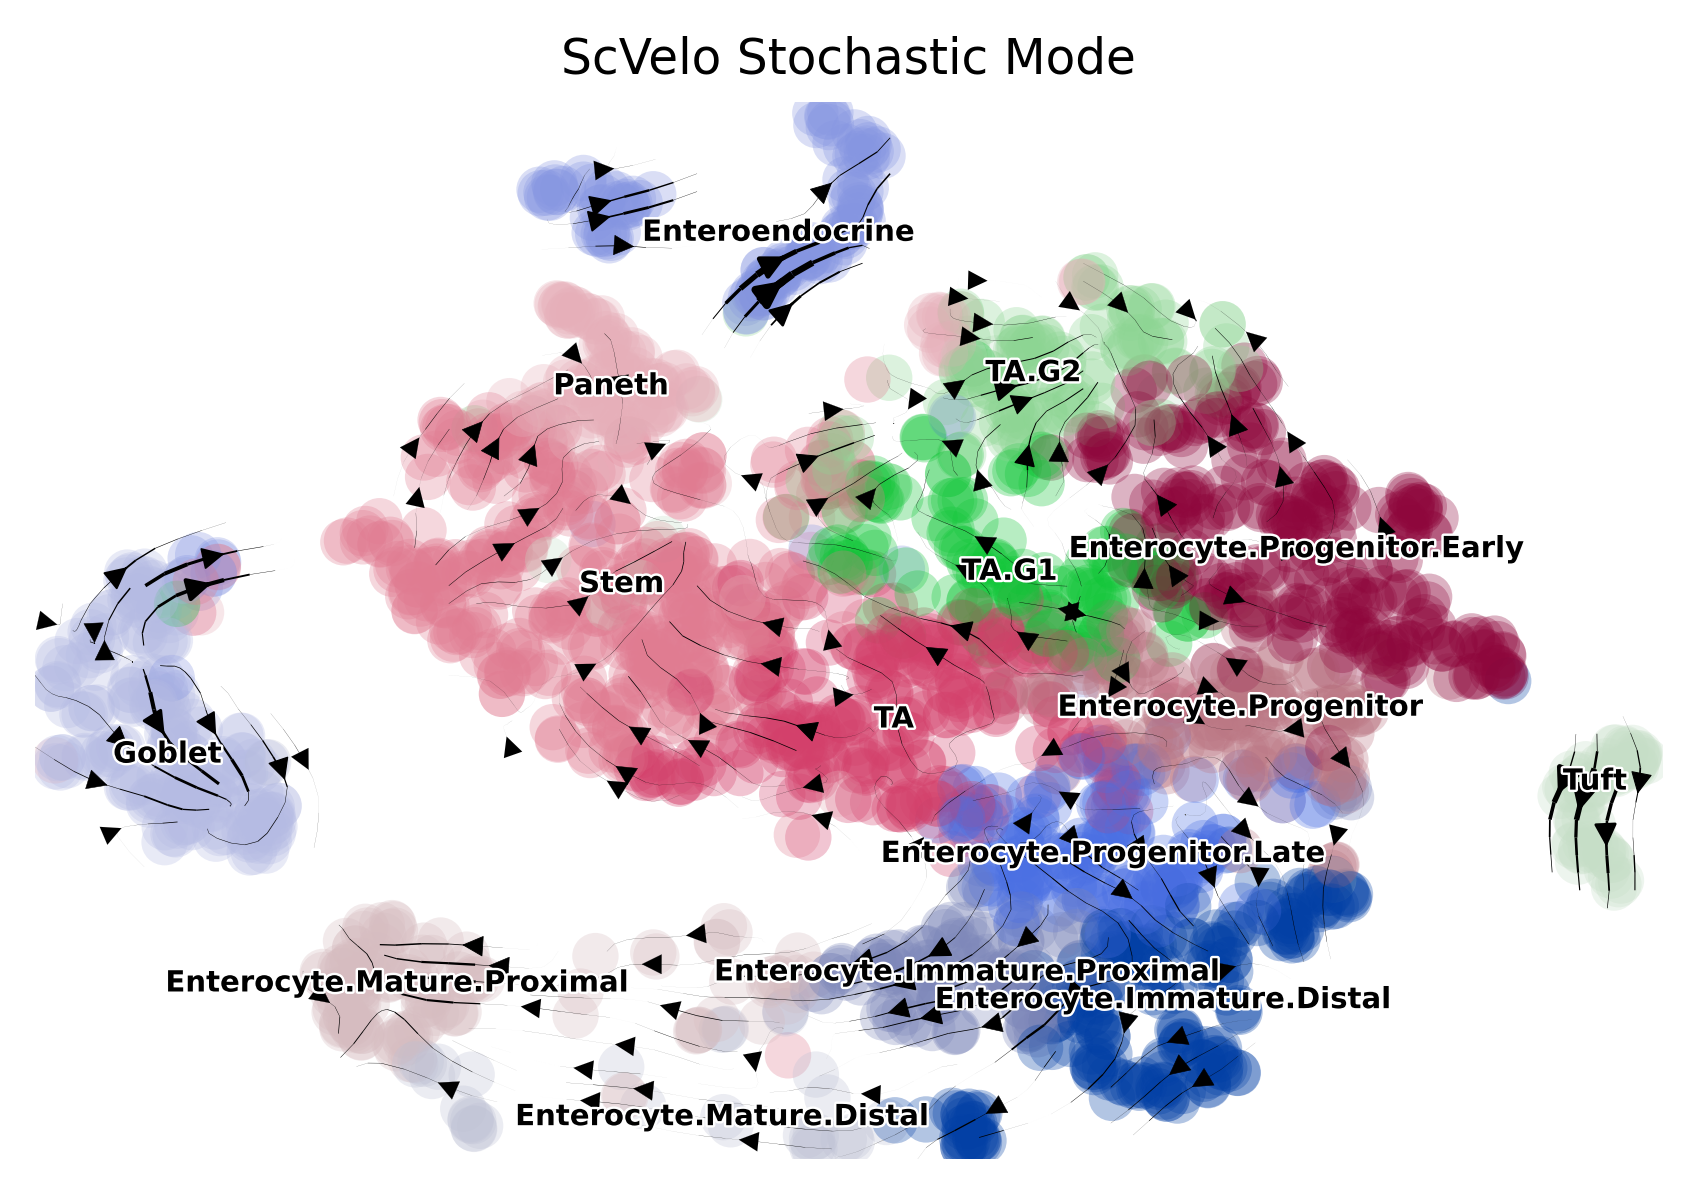

# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'Enterocyte.Immature.Distal': 0.6418838, 'Enterocyte.Immature.Proximal': 0.6378474, 'Enterocyte.Mature.Distal': 0.8474566, 'Enterocyte.Mature.Proximal': 0.83673745, 'Enterocyte.Progenitor': 0.62591416, 'Enterocyte.Progenitor.Early': 0.5943264, 'Enterocyte.Progenitor.Late': 0.5972137, 'Enteroendocrine': 0.77868, 'Goblet': 0.7269082, 'Paneth': 0.64226633, 'Stem': 0.5366147, 'TA': 0.58351207, 'TA.G1': 0.602781, 'TA.G2': 0.5739469, 'Tuft': 0.80288625}
Total Mean: 0.6685983538627625
# In-cluster Confidence
{'Enterocyte.Immature.Distal': 0.8102177776536852, 'Enterocyte.Immature.Proximal': 0.7578032119352309, 'Enterocyte.Mature.Distal': 0.7551365639224197, 'Enterocyte.Mature.Proximal': 0.7671622515634726, 'Enterocyte.Progenitor': 0.8056576524462019, 'Enterocyte.Progenitor.Early': 0.773

In [11]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                # legend_loc="right margin", 
                                vkey="stc_velocity", 
                                basis='X_umap', 
                                color=[k_cluster],
                                dpi=350, 
                                legend_fontsize=6,
                                save="intestinal_stc.png",
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 0.029954
Train Epoch: 200/20000 	Loss: 0.029755
Train Epoch: 300/20000 	Loss: 0.029513
Train Epoch: 400/20000 	Loss: 0.029275
Train Epoch: 500/20000 	Loss: 0.029070
Train Epoch: 600/20000 	Loss: 0.028772
Train Epoch: 700/20000 	Loss: 0.028407
Train Epoch: 800/20000 	Loss: 0.028059
Train Epoch: 900/20000 	Loss: 0.027746
Train Epoch: 1000/20000 	Loss: 0.027476
Train Epoch: 1100/20000 	Loss: 0.027260
Train Epoch: 1200/20000 	Loss: 0.027086
Train Epoch: 1300/20000 	Loss: 0.026928
Train Epoch: 1400/20000 	Loss: 0.026757
Train Epoch: 1500/20000 	Loss: 0.026595
Train Epoch: 1600/20000 	Loss: 0.026467
Train Epo

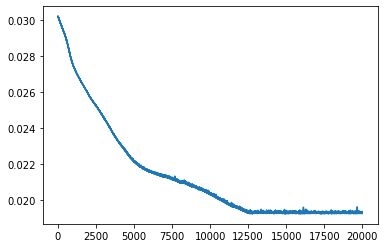

In [12]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
or is corrupte

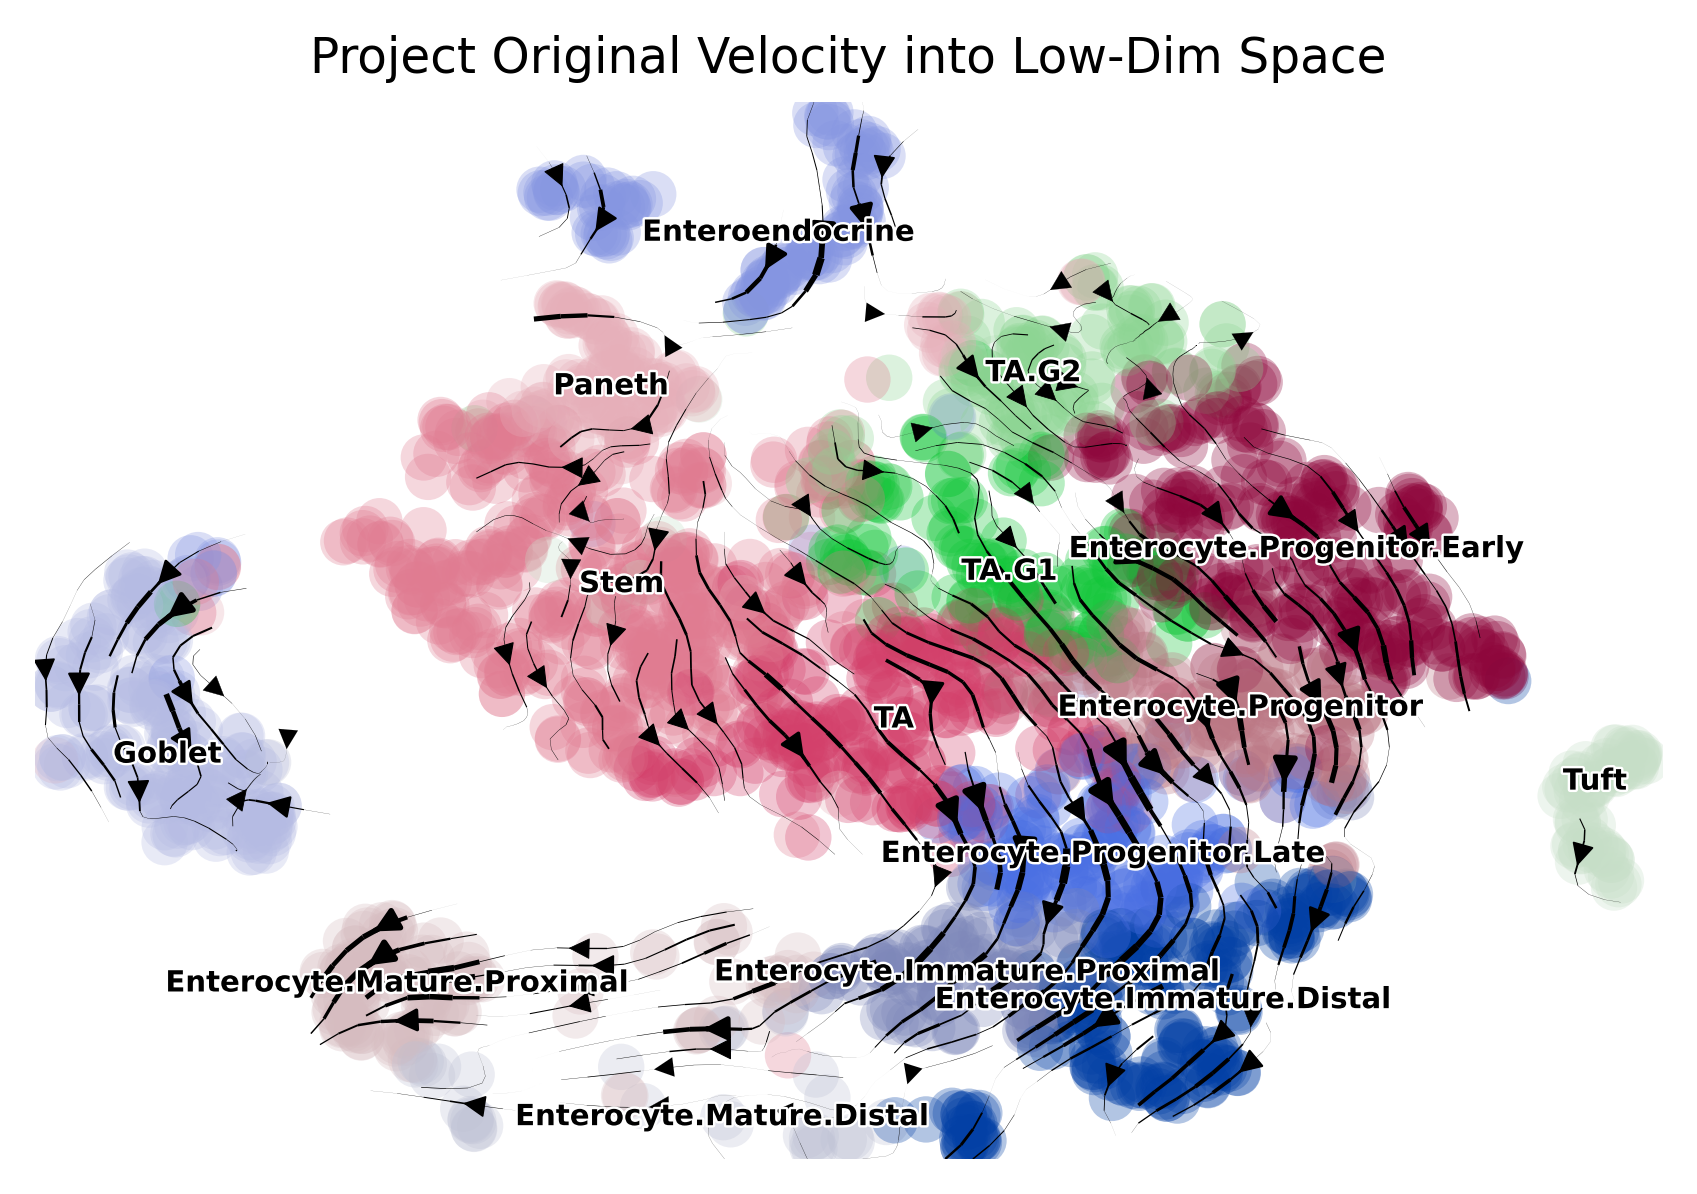

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'Enterocyte.Immature.Distal': 0.9994687, 'Enterocyte.Immature.Proximal': 0.999513, 'Enterocyte.Mature.Distal': 0.9997554, 'Enterocyte.Mature.Proximal': 0.99967456, 'Enterocyte.Progenitor': 0.9994803, 'Enterocyte.Progenitor.Early': 0.99963665, 'Enterocyte.Progenitor.Late': 0.99949646, 'Enteroendocrine': 0.9998292, 'Goblet': 0.9997655, 'Paneth': 0.99936587, 'Stem': 0.9994742, 'TA': 0.99937403, 'TA.G1': 0.9995817, 'TA.G2': 0.99961185, 'Tuft': 0.9999565}
Total Mean: 0.9995989203453064
# In-cluster Confidence
{'Enterocyte.Immature.Distal': 0.9992502548222272, 'Enterocyte.Immature.Proximal': 0.9992080511616879, 'Enterocyte.Mature.Distal

In [13]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        spliced = adata.layers['Ms']
        unspliced = adata.layers['Mu']
        tensor_s = torch.FloatTensor(spliced).to(device)
        tensor_u = torch.FloatTensor(unspliced).to(device)
        tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    scv.pp.neighbors(adata)
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.pp.neighbors(adata)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, # legend_loc='right_margin', 
                                    vkey="new_velocity", basis='X_umap', color=[k_cluster],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=350, legend_fontsize=6,
                                    save='intestinal_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
exp(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)

Extracted 2000 highly variable genes.
2000


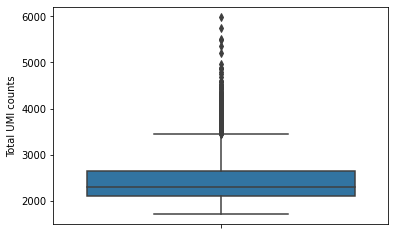

In [15]:
import seaborn as sns
adata_cp = adata.copy()
scv.pp.filter_and_normalize(adata, # min_shared_counts=20, 
                            n_top_genes=args.n_raw_gene)
adata_cp = adata_cp[:, adata.var_names]
n_umis = np.sum(adata.X.toarray(), axis=1)
df = pd.DataFrame()
df['Total UMI counts'] = n_umis
sns.boxplot(data=df, y='Total UMI counts')
print(adata_cp.n_vars)